# Visualize current state - plot COVID data

In [1]:
countryToAnalyze = "India"
stateToAnalyze ="Karnataka"

In [2]:
%run ./Load-Data.ipynb

In [3]:
#from pandas_profiling import ProfileReport

##profile = ProfileReport(confirmedDf, title='Confirmed - Pandas Profiling Report', html={'style':{'full_width':True}})
#profile = ProfileReport(confirmedDf)

#profile
##profile.to_widgets()
##profile.to_notebook_iframe()

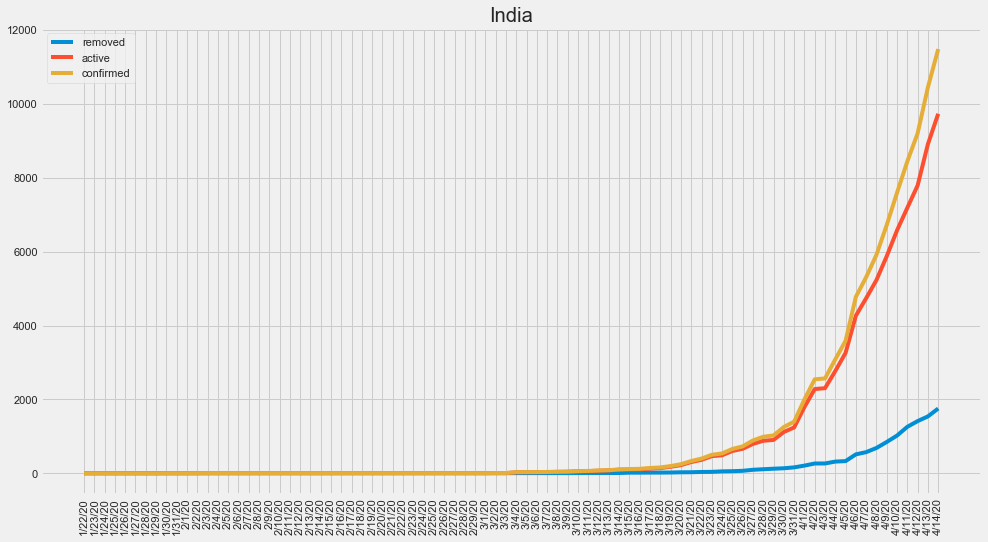

In [21]:
from matplotlib import pyplot
%matplotlib inline

pyplot.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
pyplot.rcParams['figure.figsize'] = 15, 8

confirmedTSDf, activeTSDf, removedTSDf, deathsTSDf, recoveredTSDf = getCountryTimeSeries(countryToAnalyze) 

fig = pyplot.figure(1)
pyplot.title(countryToAnalyze)
pyplot.xticks(rotation=90)
pyplot.plot(removedTSDf, label = "removed")
pyplot.plot(activeTSDf, label = "active")
pyplot.plot(confirmedTSDf, label="confirmed")
pyplot.legend()

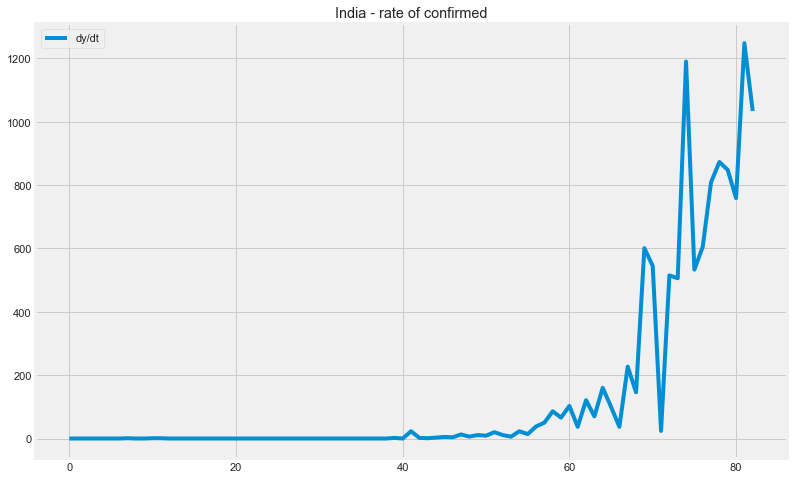

In [26]:
%matplotlib inline
import numpy as np
dy_dt= np.diff(confirmedTSDf.values.flatten())
f, ax = pyplot.subplots(figsize=(12, 8))
pyplot.title(countryToAnalyze+" - rate of confirmed")
pyplot.plot(dy_dt, label="dy/dt")
pyplot.legend()

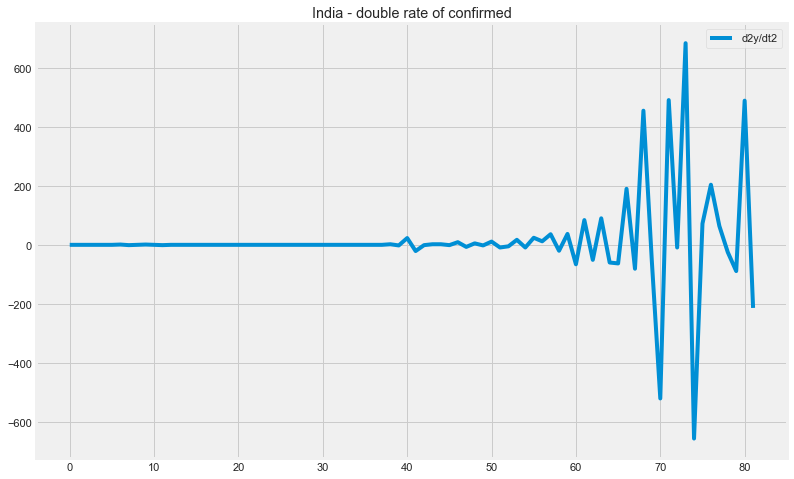

In [27]:
d2y_dt2= np.diff(dy_dt)
f, ax = pyplot.subplots(figsize=(12, 8))
pyplot.title(countryToAnalyze+" - double rate of confirmed")
pyplot.plot(d2y_dt2, label="d2y/dt2")
pyplot.legend()

# Analyze statewise for India 

## Hospital Capacity

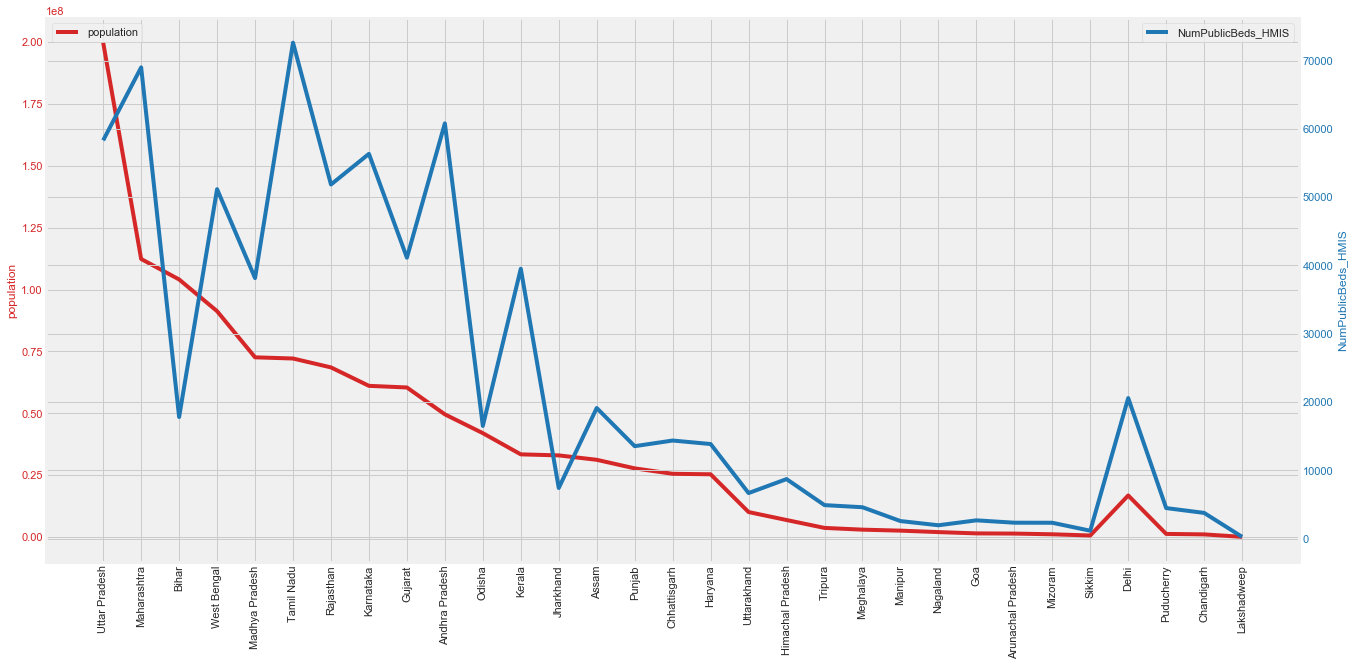

In [34]:
%matplotlib inline


hospitalBedsDf.dropna(axis=0, how='all', inplace=True)
hospitalBedsDf = hospitalBedsDf.fillna(-1)
hospitalBedsDf = hospitalBedsDf.loc[hospitalBedsDf["State/UT"] != "All India"]
hospitalBedsDf["State / Union Territory"] = hospitalBedsDf["State/UT"]

populationHospitalBedsdf = pd.merge(indiaPopulationDf, hospitalBedsDf, on=['State / Union Territory'])
states = populationHospitalBedsdf["State / Union Territory"]

fig, ax1 = pyplot.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_ylabel('population', color=color)
pyplot.xticks(rotation=90)
ax1.plot(states, populationHospitalBedsdf["Population"], label ="population", color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('NumPublicBeds_HMIS', color=color)

ax2.plot(states, populationHospitalBedsdf["NumPublicBeds_HMIS"].astype(int), label="NumPublicBeds_HMIS", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=2)
ax2.legend(loc=1)   

## State-wise numbers

In [9]:
covidIndiaLastDayDataDf = pd.DataFrame(columns=covidIndiaDataDf.columns.values)

covidIndiaLastDayDataDf.insert(len(covidIndiaDataDf.columns), "dy_dt", [], True)
covidIndiaLastDayDataDf.insert(len(covidIndiaDataDf.columns), "d2y_dt2", [], True)
covidIndiaLastDayDataDf.insert(len(covidIndiaDataDf.columns), "days", [], True)


for state in states:
    stateDataDf = covidIndiaDataDf.loc[covidIndiaDataDf["State/UnionTerritory"] ==state]
    stateDataDf.sort_values('Date',ascending=False,inplace=True)
    if stateDataDf.shape[0] != 0:
        covidIndiaLastDayDataDf = covidIndiaLastDayDataDf.append(stateDataDf.iloc[0])
        dy_dt= np.diff(stateDataDf["Confirmed"].values.astype(int))
        d2y_dt2= np.diff(dy_dt)
        days = 0
        if len(stateDataDf.index) > 0:
            date = stateDataDf.index[-1]
            days = (stateDataDf.index[0] - stateDataDf.index[-1]).days
            #print(days)
        else:
            date=datetime.strptime("1/1/1970", '%d/%m/%y')
        if date == 0:
            date=datetime.strptime("1/1/1970", '%d/%m/%y')
        last_dy_dt = 0
        if dy_dt.shape[0] != 0:
            last_dy_dt = dy_dt[0]
        last_d2y_dt2 = 0
        if d2y_dt2.shape[0] != 0:
            last_d2y_dt2 = d2y_dt2[0]
        covidIndiaLastDayDataDf.iloc[-1,-1] = -1*last_dy_dt
        covidIndiaLastDayDataDf.iloc[-1, -2] = -1*last_d2y_dt2
        covidIndiaLastDayDataDf.iloc[-1, -3] = days
    else:
        covidIndiaLastDayDataDf = covidIndiaLastDayDataDf.append(pd.Series(), ignore_index=True)
        covidIndiaLastDayDataDf.iloc[-1, 1] = state
    

covidIndiaLastDayDataDf.fillna(0, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


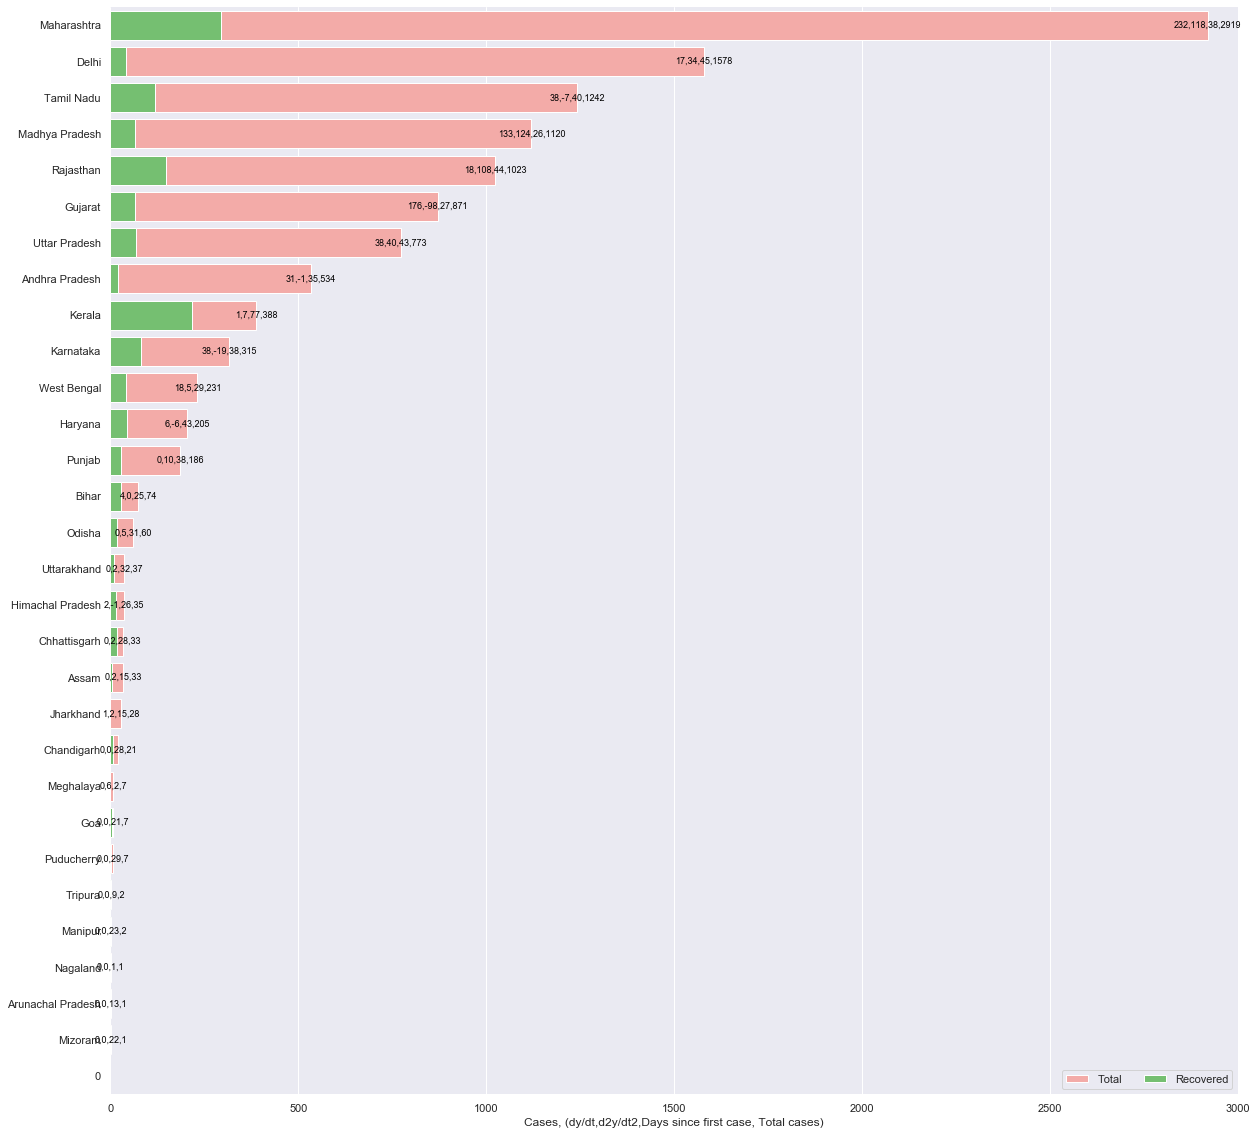

In [10]:
import seaborn as sns

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()

f, ax = pyplot.subplots(figsize=(18, 20))
covidIndiaLastDayDataDf['Name of State / UT']=covidIndiaLastDayDataDf['State/UnionTerritory']
covidIndiaLastDayDataDf['Total cases']=covidIndiaLastDayDataDf['Confirmed']
covidIndiaLastDayDataDf['Cured/Discharged/Migrated']=covidIndiaLastDayDataDf['Cured']
data = covidIndiaLastDayDataDf[['Name of State / UT','Total cases','Cured/Discharged/Migrated','Deaths', 'dy_dt', 'd2y_dt2', 'days']]

data.sort_values('Total cases',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="Total cases", y="Name of State / UT", data=data,
            label="Total", color="r", ci=None)

sns.set_color_codes("muted")
g =sns.barplot(x="Cured/Discharged/Migrated", y="Name of State / UT", data=data,
            label="Recovered", color="g", ci=None)


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 3000), ylabel="",
       xlabel="Cases, (dy/dt,d2y/dt2,Days since first case, Total cases)")
sns.despine(left=True, bottom=True)


order = 0
for index, row in data.iterrows():
    val = str(int(row['dy_dt'])) + "," + str(int(row['d2y_dt2'])) + "," + str(int(row['days'])) + ","+str(row["Total cases"])
    if val != "0,0,0,0":
        g.text(row["Total cases"], order, val, color='black', ha="center", fontsize=9, horizontalalignment='left',  verticalalignment='center')
    order += 1
    

## Testing to positive - trend and ratio

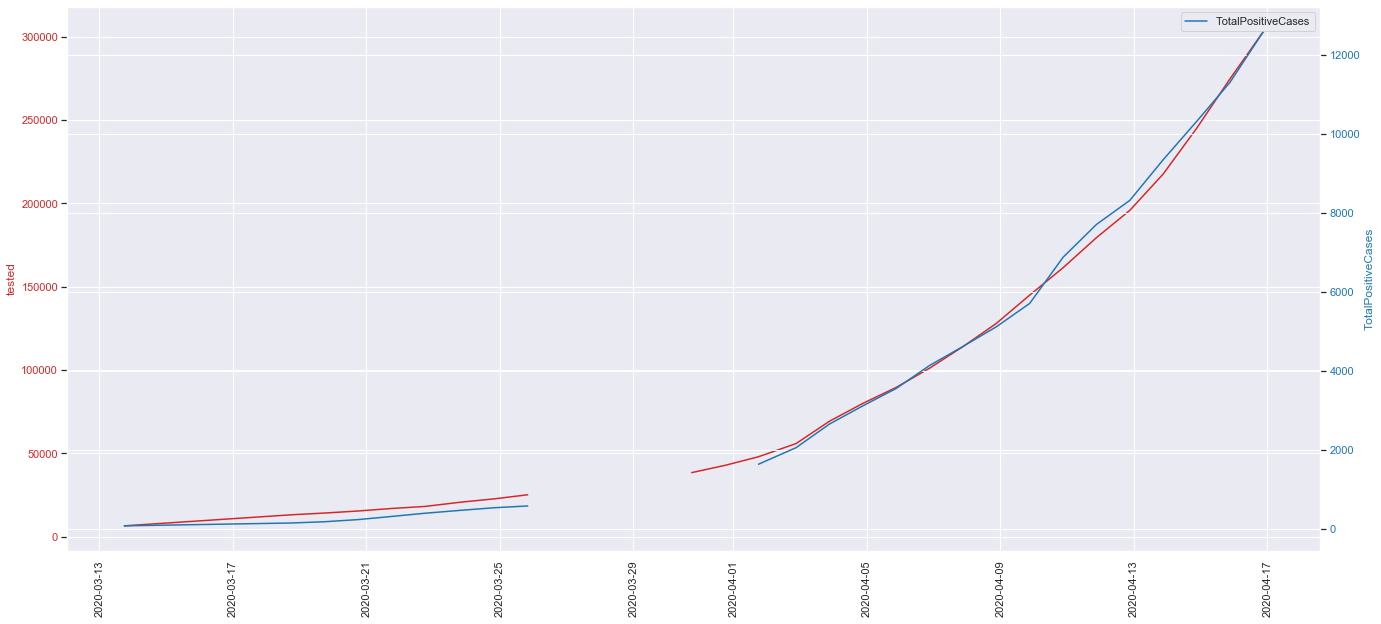

In [11]:
fig, ax1 = pyplot.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_ylabel('tested', color=color)
pyplot.xticks(rotation=90)
ax1.plot(icmrTestingDf["DateTime"], icmrTestingDf["TotalSamplesTested"], label ="TotalSamplesTested", color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('TotalPositiveCases', color=color)

ax2.plot(icmrTestingDf["DateTime"], icmrTestingDf["TotalPositiveCases"], label="TotalPositiveCases", color=color)
ax2.tick_params(axis='y', labelcolor=color)
pyplot.legend()


# Giving an Index to states based on their handling - where to focus?

Lower the better

In [12]:
#Penalty for delay since first case
data["responseIndex"] = (0.001+data["days"])
#Penalty for rate of growth of cases
data["responseIndex"] = data["responseIndex"] + data["responseIndex"] * 1000*(0.001+data["dy_dt"])
#Penalty if the rate of rate itself is up
data["responseIndex"] = data["responseIndex"] + data["responseIndex"] * 1000*(0.001+data["d2y_dt2"])

data["responseIndex"] = data["responseIndex"] + data["responseIndex"] *100*(0.001+data["Total cases"])/(data["Total cases"].sum())

data.sort_values('responseIndex',ascending=False,inplace=True)
data.reset_index()
indexData = data[['Name of State / UT', 'responseIndex']]
indexData.drop(index=0, inplace=True)
display(indexData)

,Name of State / UT,responseIndex
1,Maharashtra,2.692034e+13
4,Madhya Pradesh,4.521892e+12
6,Rajasthan,8.313880e+11
27,Delhi,3.758700e+11
3,West Bengal,7.752396e+09
11,Kerala,2.326616e+09
12,Jharkhand,3.727298e+07
14,Punjab,1.965155e+06
10,Odisha,4.687189e+05
2,Bihar,3.263070e+05


# Analyze a particular State

In [13]:
covidStateDataDf = covidIndiaDataDf.loc[covidIndiaDataDf["State/UnionTerritory"]==stateToAnalyze]

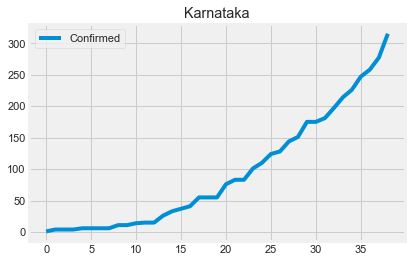

In [30]:
%matplotlib inline
pyplot.figure(1)
pyplot.title(stateToAnalyze)
pyplot.plot(covidStateDataDf["Confirmed"].values, label="Confirmed")
pyplot.legend()

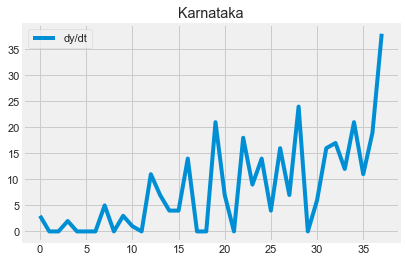

In [31]:
dy_dt= np.diff(covidStateDataDf["Confirmed"].values)
pyplot.figure(1)
pyplot.title(stateToAnalyze)
pyplot.plot(dy_dt, label="dy/dt")
pyplot.legend()

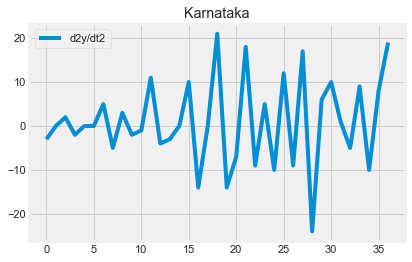

In [32]:
d2y_dt2= np.diff(dy_dt)
pyplot.figure(1)
pyplot.title(stateToAnalyze)
pyplot.plot(d2y_dt2, label="d2y/dt2")
pyplot.legend()